In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Audio
from ipywidgets import interact, interactive

In [2]:
def tfPlot(sig, fs=44100, timeLen=None):
    """
    Function for getting a time/frequency domain plot.
    """
    N = len(sig)
    t = np.arange(N)/fs
    plt.figure(figsize=[17,5])
    plt.subplot(121)
    plt.title('Time Domain')
    plt.plot(t,sig)
    if timeLen !=None:
        plt.xlim([0,timeLen])
    plt.grid()
    plt.xlabel('Time[sec]')
    plt.subplot(122)

    plt.semilogx(np.linspace(1,fs/2, int(N/2)), abs(np.fft.fft(sig))[0:int(N/2)])
    plt.xlabel('Freq[Hz]')
    plt.title('Spectrum')
    plt.grid()
    plt.show()



# Naive Sawtooth

- will inevitably lead to aliasing at higher frequencies

In [3]:
# naive sawtooth

def makeNaiveSaw(f1=100):
    T = 0.3 #sec
    fs = 44100. #Hz
    N = T*fs #num Samples
    n = np.arange(N)+1. #sample Index
    t = n/fs #time

    freq = f1 #Hz
    P = 1/freq * fs # (1/freq)*fs
    
    y = np.zeros(int(N))

    for i in range(len(n)):
        y[i] = 2* ((i % P)/P - 0.5)

    tfPlot(y, timeLen=4*P/fs)
    return y


In [4]:
naive_saw_widget = interactive(makeNaiveSaw, f1=(20.0,5000.0), continuous_update=False)
display(naive_saw_widget)

interactive(children=(FloatSlider(value=100.0, description='f1', max=5000.0, min=20.0), Output()), _dom_classe…

In [25]:
Audio(data=naive_saw_widget.result, rate=44100)

### Additive Synthesis

have to programmatically control aliasing partials

### Heavy Upsampling

brute force method, additional CPU load

### Wavetable Synthesis

simple approach that will lead to decent results in many cases

# Bandlimited Impulse Trains (BLITs)

Another naive way to obtain a sawtooth is to integrate a unit impulse train, only that the unit impulse contains all frequencies per definition. 

So integrating it will lead to an infinite number of partials.


In [6]:
def makeSimpleImpulseTrain(f1=100):
    T = 0.3 #sec
    fs = 44100. #Hz
    N = T*fs #num Samples
    n = np.arange(N)+1. #sample Index
    t = n/fs #time

    freq = f1 #Hz
    P = 1/freq * fs # (1/freq)*fs
    
    y = np.zeros(int(N))

    for i in range(len(n)):
        y[i] = 1 if np.floor(i % P) == 0 else 0

    tfPlot(y, timeLen=4*P/fs)
    return y
    

In [7]:
simple_it_widget = interactive(makeSimpleImpulseTrain, f1=(20.0,5000.0), continuous_update=False)
display(simple_it_widget)

interactive(children=(FloatSlider(value=100.0, description='f1', max=5000.0, min=20.0), Output()), _dom_classe…

In [8]:
Audio(data=simple_it_widget.result, rate=44100)

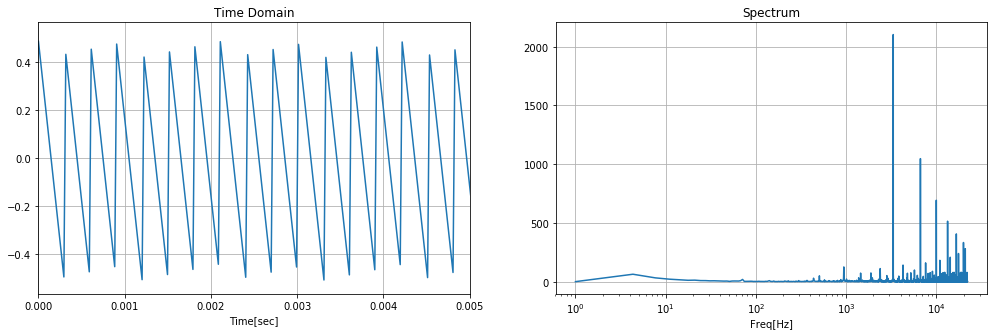

In [26]:
avg = np.average(simple_it_widget.result) #get DC component 
simple_saw = np.cumsum(simple_it_widget.result-avg) # integrate after removing the dc component
simple_saw -= np.average(simple_saw) #remove DC component of result

tfPlot(simple_saw, fs=44100, timeLen=0.005)

In [27]:
Audio(data=simple_saw, rate=44100)

The impulse response of an ideal (brickwall) anti-aliasing filter is a $sinc$:

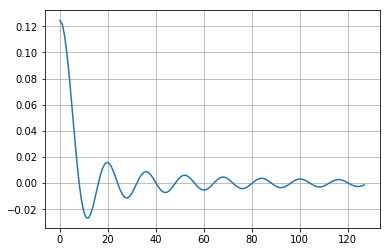

In [42]:
brickwall_filter = np.ones(1024)
brickwall_filter[128:] = 0

plt.plot(np.fft.irfft(brickwall_filter)[0:128])
plt.grid()
plt.show()



A **BLIT** signal, $y(n)$ with $P$ as Period in Samples is given by:

$$ y(n) = (M/P) Sinc_M[(M/P)n] $$
where


$$ Sinc_M(x) = \frac{sin( \pi x)}{M sin(\pi x /M)}$$

$M$ = Number of Harmonics

Calculated via
$$ M = 2\cdot floor(P/2)+1 $$

## Issues:
- the denominator of `sincM` will be 0 if $n$ is an integer factor of $P$
- the numerator of `sincM` will be 0 if $x$ is an integer, which will be the case when $M = P$
- Both Filters for the Realtime Sawtooth probably need to be slightly frequency dependent.


In [12]:
def sincM(x, M):
    return np.sin(np.pi*x)/(M*np.sin((np.pi*x)/M))
def sampledSinc(n,M,P):
    output = np.zeros_like(n)
    
    if M==P:
        cond = np.zeros_like(n, dtype=bool)
        condInv = np.ones_like(n, dtype=bool)
    else:    
        cond = ((n / P) % 1 != 0)
        condInv = ((n / P) % 1 == 0)

    output[cond] = (M/P)*sincM((M/P)*n[cond], M)
    P-=0.001
    output[condInv] = (M/P)*sincM((M/P)*n[condInv], M)
    return output

In [13]:
def makeBLIT(f1=100):
    T = 0.3 #sec
    fs = 44100. #Hz
    N = T*fs #num Samples
    n = np.arange(N)+1. #sample Index
    t = n/fs #time

    freq = f1 #Hz
    T1 = 1./freq #period in Seconds
    Ts = 1./fs #sampling Period
    P = T1/Ts # (1/freq)*fs
    
    M = 2*np.floor(P/2.)+1 #Number of Harmonics
    y = sampledSinc(n, M, P)
    tfPlot(y, timeLen=4*P/fs)
    return y

In [14]:
blit_widget = interactive(makeBLIT, f1=(20.0,5000.0), continuous_update=False)
display(blit_widget)

interactive(children=(FloatSlider(value=100.0, description='f1', max=5000.0, min=20.0), Output()), _dom_classe…

In [15]:
Audio(data=blit_widget.result, rate=44100)

# Sawtooth

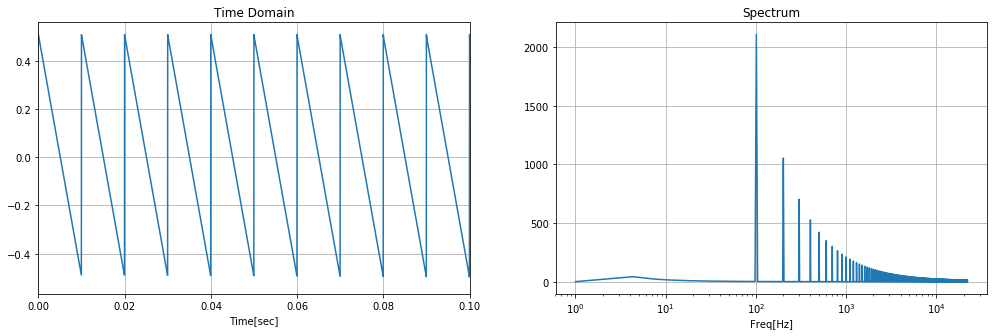

In [16]:
avg = np.average(blit_widget.result) #get DC component of BLIT
blit_saw = np.cumsum(blit_widget.result-avg) # integrate after removing the dc component
blit_saw -= np.average(blit_saw) #remove DC component of result

tfPlot(blit_saw, fs=44100, timeLen=0.1)

In [17]:
Audio(data=blit_saw, rate=44100)

# Realtime Capable Sawtooth

For the realtime Sawtooth the DC component is approximated via an IIR filter and the integration is done via a Leaky integrator (one pole). 


## Leaky Integrator 

$$ H(z) = \frac{1}{1 -z^{-1}\alpha}$$

where $\alpha$ is very close to 1.

This basically means
$$ y(n) = x(n)+y(n-1)\alpha $$



In [18]:
def leakyIntegrator(x, alpha=1-10e-6):
    return signal.lfilter([1.0, 0.], [1., -alpha], x)    

In [19]:
def runningAvg(x, alpha=0.995):
    """
    IIR aproximation of a running average
    """
    return signal.lfilter([1-alpha,0],[1,-alpha],x)

Having all that, we still use the BLIT from above as $y$:

0.0021831191334655523


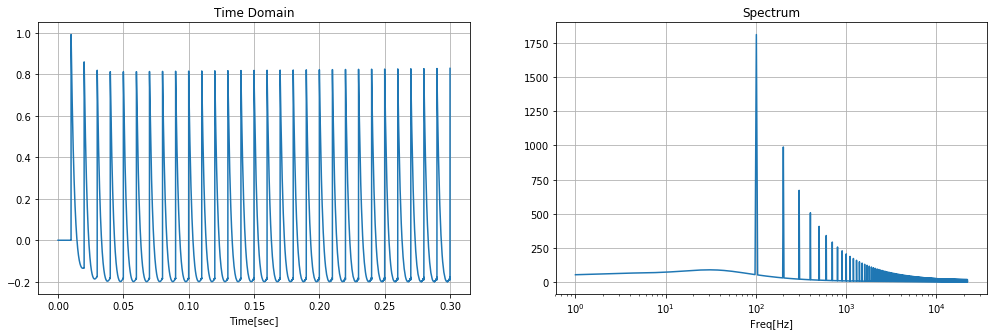

In [20]:
newAvg = runningAvg(blit_widget.result) #get DC component of BLIT
print(np.average(newAvg))
saw = leakyIntegrator(blit_widget.result-newAvg) # integrate after removing the dc component
saw -= runningAvg(saw) #remove DC component of result

tfPlot(saw, fs=44100)

In [21]:
Audio(data=saw, rate=44100)

## Sweep

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7598: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


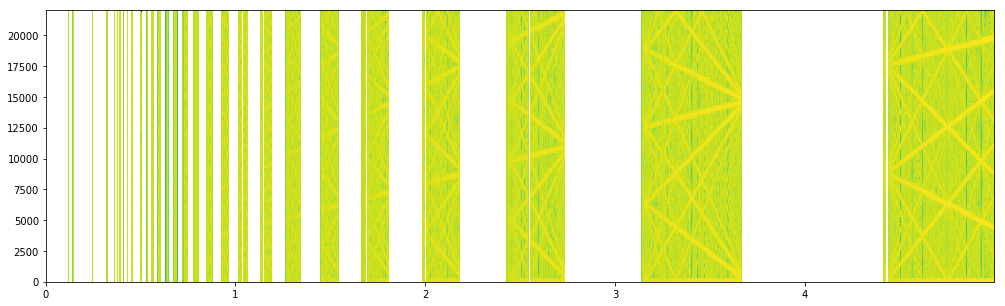

In [22]:
T = 5 #sec
fs = 44100. #Hz
N = int(T*fs) #num Samples
n = np.arange(N)+1 #sample Index
t = n/fs #time
freqSweep = np.linspace(100, 10000, N)

Y = np.zeros_like(t)


for i in range(N):
    freq = freqSweep[i] #Hz
    T1 = 1./freq #period in Seconds
    Ts = 1./fs #sampling Period
    P = T1/Ts # (1/freq)*fs
    M = 2*np.floor(P/2.)+1 #Number of Harmonics
    y = sampledSinc(np.array([i]), M, P)
    Y[i]=y

plt.figure(figsize=[17,5])
plt.specgram(Y, Fs=fs)
plt.show()
    

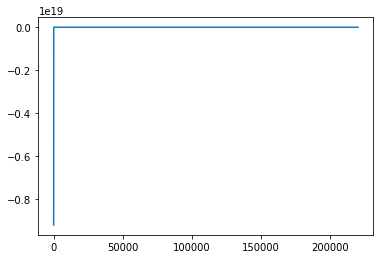

In [23]:
plt.plot(Y)
plt.show()

In [24]:
Audio(data=Y, rate=44100)

## References
https://ccrma.stanford.edu/~stilti/papers/blit.pdf    
https://ccrma.stanford.edu/~jos/fp/One_Pole.html